# Project questions:

# Distributed Data Infrastructures, Fall 2020, Project 2

Assignment
In this project, you are supposed to use GraphLab to analyze data sets. GraphLab is a high performance, open-source, big data framework which we have discussed in the course. We provide you with a data set and you should run GraphLab either on AWS or locally to analyze the data set. 

The dataset was released by Telecom Italia for their Open Big Data Challenge in 2014. It contains telecommunication records, weather, air quality, electricity consumption for city of Milan and province of Trentino in Italy in November and December 2013. You can find detailed description of the dataset from the paper:
https://www.nature.com/articles/sdata201555.

Requirements
You need write a program that uses GraphLab to provide answers to the following questions.

### First three questions are worth 2 points total.

1. Find the most congested communication period of the day in Milan and Trentino.

2. List top 5 Italian provinces which are most called by residents of Milan and Trentino on average.

3. List top 5 languages tweeted by distinct users in Milan. How popular is Finnish as a tweeting language in Milan?

### The following questions are worth 3 points total.

4. Compare call and internet activity between 24th, 25th and 26th December to 26th, 27th, 28th November for Milan. Plot the distribution.

5. Find correlation between user communication activity and different weather conditions (e.g. rain, snow etc.) in Milan and Trentino.

### The final questions are worth 2 points each.

6. Plot the heatmap of user telecommunication activity for both Milan and Trentino. Do you observe any shift in communication pattern of users between day and night? (A typical day time is between 8AM to 8PM)

7. Investigate and plot the correlation between air quality and weather (temperature, sunshine, precipitation, etc.).

### Read libraries

In [1]:
import pandas as pd
from turicreate import SFrame, SGraph, Vertex, Edge
import arrow
import glob2
import time
from datetime import datetime as dt
import turicreate.aggregate as agg
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Find the most congested communication period of the day in Milan and Trentino.

Answer to this question based on the telecommunication data for Milan and Trentino on 24th December 2013. Answer will be the most congested hour in the given day.

#### Telecommunication data has folllowing information:

0. Square id: identification string of a given square of Milan/Trentino GRID;

1. Time Interval: start interval time expressed in milliseconds. The end interval time can be obtained by adding 600,000 milliseconds (10 min) to this value;

2. Country code: the phone country code of the nation.

3. SMS-in activity: activity proportional to the amount of received SMSs inside a given Square id and during a given Time interval. The SMSs are sent from the nation identified by the Country code.

4. SMS-out activity: activity proportional to the amount of sent SMSs inside a given Square id during a given Time interval. The SMSs are received in the nation identified by the Country code;

5. Call-in activity: activity proportional to the amount of received calls inside the Square id during a given Time interval. The calls are issued from the nation identified by the Country code;

6. Call-out activity: activity proportional to the amount of issued calls inside a given Square id during a given Time interval. The calls are received in the nation identified by the Country code;

7. Internet traffic activity: number of CDRs generated inside a given Square id during a given Time interval. The Internet traffic is initiated from the nation identified by the Country code;

In [2]:
# Define function to find peak hour for the day
def peak_n_hours(sframe, n):
    # Add hour column
    sframe['hour'] = sframe['Time'].apply(lambda t: dt.utcfromtimestamp(t/1e3).strftime('%H'))
    
    # Calculate hourly activity
    sf_hourly = sframe.groupby(key_column_names = 'hour', operations= {'smsin':agg.SUM('SMSin'), 
                            'smsout': agg.SUM('SMSout'), 'callin':agg.SUM('call_in'),
                            'callout': agg.SUM('call_out'), 'int_traffic': agg.SUM('internet_traffic')})
    
    # Calculate sum of the activity volumns
    sf_hourly['total'] = sf_hourly['smsin']+sf_hourly['smsout']+sf_hourly['callin']+sf_hourly['callout']+sf_hourly['int_traffic']
    
    # Drop other columns except hour and total
    sf = sf_hourly["hour", "total"]
    
    # Sort sf_hourly and fet 5 largest values
    sf = sf.sort('total', ascending=False)
    
    # Return n first hours and their total activity
    return sf.head(n)

In [3]:
# Set path to files
milano_dec24_path = 'data/milano_telecom_dec/sms-call-internet-mi-2013-12-14.txt'
trentino_dec24_path = 'data/trento_telecom_dec/sms-call-internet-tn-2013-12-14.txt'

# Read the files. SFrame is not able to handle rows with different lengths, 
# so first read data with pandas and then convert to SFrame
milano = pd.read_csv(milano_dec24_path, sep="\t", header=None).fillna(0)
milano = SFrame(milano)
trentino = pd.read_csv(trentino_dec24_path, sep="\t", header=None).fillna(0)
trentino = SFrame(trentino)

# Add column names to SFrames
milano = milano.rename({'0': 'SquareID', '1':'Time', '2':"country_code", "3":"SMSin", "4":"SMSout", "5":"call_in" , "6":"call_out", "7":"internet_traffic"})
trentino = trentino.rename({'0': 'SquareID', '1':'Time', '2':"country_code", "3":"SMSin", "4":"SMSout", "5":"call_in" , "6":"call_out", "7":"internet_traffic"})

# Run function and print n=5 busiest communication hours
print("The most congested communication hours of the 24th Dec 2013 in Milan")
print(peak_n_hours(milano, 5))
print("The most congested communication hours of the 24th Dec 2013 in Trentino")
print(peak_n_hours(trentino, 5))


The most congested communication hours of the 24th Dec 2013 in Milan
+------+--------------------+
| hour |       total        |
+------+--------------------+
|  16  | 5416257.583677514  |
|  11  | 5371330.078746548  |
|  17  | 5344031.796636868  |
|  10  | 5337831.324568588  |
|  15  | 5284227.5582101345 |
+------+--------------------+
[5 rows x 2 columns]

The most congested communication hours of the 24th Dec 2013 in Trentino
+------+--------------------+
| hour |       total        |
+------+--------------------+
|  16  | 1036600.3784612637 |
|  10  | 1029579.4795295174 |
|  17  | 1011900.8027854215 |
|  11  | 1007262.7792211808 |
|  15  | 1006217.5522763166 |
+------+--------------------+
[5 rows x 2 columns]



## 2. List top 5 Italian provinces which are most called by residents of Milan and Trentino on average.

I will answer to this question based on the "Milan/trentino to provinces" telecommunication dataset on 24th December 2013.

Milan/trentino to provinces dataset has following columns:

0. Square id: identification string of a given square of Milan/Trentino GRID;

1. Time Interval: Start interval time expressed in milliseconds. The end interval time can be obtained by adding 600,000 milliseconds (10 min) to this value;

2. Square to Province Inter: Value representing the interaction between the Square id and the Province. It is proportional to the number of calls exchanged between callers, which are located in the Square id, and receivers located in the Province;

3. Province to Square Inter: Value representing the interaction between the Square id and the Province. It is proportional to the number of calls exchanged between callers, which are located in the Province, and receivers located in the Square id.

4. Province: the name of the Italian province.

In [4]:
def most_called_provinces(sframe):
    # Rename columns
    sframe = sframe.rename({'0': 'SquareID', '1':'Province', '2':"Time", "3":"SqrtToProvince", "4":"ProvinceToSqrt"})
    
    # Drop columns where ProvinceToSqrt=0. These rows are incoming calls from provinces 
    # and we want only count calls to provinces.
    sframe = sframe[sframe["SqrtToProvince"] > 0]
    
    # Count by provinces
    famous_prov = sframe.groupby(key_column_names = 'Province', operations= {'count': agg.COUNT()})
    
    # Sort by count and return top5 provinces
    return famous_prov.sort('count', ascending=False).head(5)


In [5]:
# Set path to files
milano_dec24_path = 'data/milano_provinces_telecom/mi-to-provinces-2013-12-24.txt'
trentino_dec24_path = 'data/trento_provinces_dec/tn-to-provinces-2013-12-24.txt'

# Read the files. SFrame is not able to handle rows with different lengths, 
# so first read data with pandas and then convert to SFrame
milano = pd.read_csv(milano_dec24_path, sep="\t", header=None).fillna(0)
milano = SFrame(milano)
trentino = pd.read_csv(trentino_dec24_path, sep="\t", header=None).fillna(0)
trentino = SFrame(trentino)

# Run function and print top 5 provinces most called by residents
print("The most called provinces from Milano on the 24th Dec 2013")
print(most_called_provinces(milano))
print("The most called provinces from Trentino on the 24th Dec 2013")
print(most_called_provinces(trentino))

The most called provinces from Milano on the 24th Dec 2013
+-----------------------+--------+
|        Province       | count  |
+-----------------------+--------+
|         MILANO        | 970483 |
| MONZA E DELLA BRIANZA | 217406 |
|         PAVIA         | 175663 |
|         VARESE        | 85739  |
|         NAPOLI        | 84398  |
+-----------------------+--------+
[5 rows x 2 columns]

The most called provinces from Trentino on the 24th Dec 2013
+---------------+--------+
|    Province   | count  |
+---------------+--------+
|     TRENTO    | 527030 |
| BOLZANO/BOZEN | 107719 |
|    BRESCIA    | 80951  |
|     VERONA    | 59680  |
|     MILANO    | 54876  |
+---------------+--------+
[5 rows x 2 columns]



## 3. List top 5 languages tweeted by distinct users in Milan. How popular is Finnish as a tweeting language in Milan?

The SocialPulse dataset [Data citations 10,11] contains geolocalized tweets originated from Milan between November 1, 2013 and January 1st, 2014.

0. user: anonymized Twitter username;

1. language: language of the Tweet, where und means undefined;

2. municipality: the municipality in which the tweet has been probably created. The approximation is the same of the geometry field (see below). The municipality field is composed of the municipality name and the Dandelion acheneID, specified in the Administrative Regions dataset. Users can get more data about the municipality (e.g., boundaries, population) using the acheneID as a primary key in the Administrative Regions;

3. timestamp: Tweet timestamp;

4. geometry latitude: approximate position of the tweet, in geoJSON format. Error <600 m.

5. geometry longitude: approximate position of the tweet, in geoJSON format. Error <600 m.

In [6]:
# Set path to file
milano_path = 'data/social_pulse/social_pulse_milano.csv'

# Read the files
milano = SFrame.read_csv(milano_path, sep="\t", header=None)

# Rename columns
milano = milano.rename({'X1': 'user', 'X2':'language', 'X3':"municipality", "X4":"timestamp", "X5":"latitude", "X6":"longitude"})
    
# Count language
languages_count = milano.groupby(key_column_names = 'language', operations= {'count': agg.COUNT()})

# Sort languages by count
languages_count = languages_count.sort('count', ascending=False)

# Print 15 most populat tweeting languages
languages_count.print_rows(num_rows=15)

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/social_pulse/social_pulse_milano.csv

Parsing completed. Parsed 100 lines in 0.180461 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,str,int,float,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/social_pulse/social_pulse_milano.csv

Parsing completed. Parsed 269290 lines in 0.170962 secs.

+----------+--------+
| language | count  |
+----------+--------+
|    it    | 163889 |
|    en    | 47830  |
|    es    |  7745  |
|    tl    |  6815  |
|    pt    |  5162  |
|    so    |  4013  |
|    fr    |  3654  |
|    id    |  3183  |
|   und    |  3132  |
|    de    |  2183  |
|    tr    |  2065  |
|    ar    |  1886  |
|    nl    |  1754  |
|    ro    |  1746  |
|    fi    |  1594  |
+----------+--------+
[45 rows x 2 columns]



## 4. Compare call and internet activity between 24th, 25th and 26th December to 26th, 27th, 28th November for Milan. Plot the distribution.

To answer this question, I will calculate hourly call and internet activity for each day, and then make histogram of hourly activities in given days in November and December.

In [9]:
def create_hourly_telecom_SFrame(paths, start_date, end_date):
    # Measure time how long it takes. Set start time.
    start = time.time()
    
    # Filter paths by start_date and end_date
    # Path example: sms-call-internet-mi-2013-12-01.txt
    wanted_paths = []
    for path in paths:
        date = int(path[-6:-4])
        if (date <= end_date) and (date >= start_date):
            wanted_paths.append(path)
    
    # Read the files and append dataframes to result_df
    result_df = pd.DataFrame(columns = ["day", "SquareID", "Time", "country_code", "SMSin", "SMSout", "call_in" ,"call_out", "internet_traffic"])
    for path in wanted_paths:
        day = path[-6:-4]
        df = pd.read_csv(path, sep="\t", header=None)
        df = df.fillna(0)
        df.columns = ["SquareID", "Time", "country_code", "SMSin", "SMSout", "call_in" ,"call_out", "internet_traffic"]
        df["day"] = day
        result_df= result_df.append(df)
    
    # Convert Pandas dataframe to SFrame
    sf = SFrame(data=result_df)
    
    # Drop columns SquareID and country_code
    sf = sf.remove_column('SquareID')
    sf = sf.remove_column('country_code')
    
    # Add hour column and add 1 hour to time (from UTC to Rome time)
    sf["hour"] = sf["Time"].apply(lambda timestamp: arrow.get(timestamp+3600000).format('HH'))

    # Group by day and hour, and sum of each activity in each hour and day
    sf_hourly = sf.groupby(['day', 'hour'], {'callin':agg.SUM('call_in'), 
                                             'callout': agg.SUM('call_out'), 
                                             'int_traffic': agg.SUM('internet_traffic')})
    
    # Calculate sum of callin and callout
    sf_hourly["calls"] = sf_hourly["callin"]+sf_hourly["callout"]
    
    # Drop columns SquareID and country_code
    sf_hourly = sf_hourly.remove_column('callin')
    sf_hourly = sf_hourly.remove_column('callout')
    
    # Sort by day and hour
    sf_hourly = sf_hourly.sort(['day', 'hour'], ascending=True)
    
    # Set hour and day type to int
    sf_hourly["day"] = sf_hourly["day"].astype(int)
    sf_hourly["hour"] = sf_hourly["hour"].astype(int)
    
    # Print time how long it took
    end = time.time()
    print("Time to run function was", round(end - start), "seconds")

    # Return results
    return sf_hourly


In [10]:
# Execute the glob function that returns a list of filepaths
data_paths_milano_nov = glob2.glob("data/milano_telecom_nov/*")
data_paths_milano_dec = glob2.glob("data/milano_telecom_dec/*")

# Use create_telecom_SFrame to read paths and join the files within given dates
milano_nov = create_hourly_telecom_SFrame(data_paths_milano_nov, 26, 28)
milano_dec = create_hourly_telecom_SFrame(data_paths_milano_dec, 24, 26)

# Print first 5 rows
milano_nov.print_rows(num_rows=5)
milano_dec.print_rows(num_rows=5)

Time to run function was 87 seconds
Time to run function was 73 seconds
+-----+------+--------------------+--------------------+
| day | hour |    int_traffic     |       calls        |
+-----+------+--------------------+--------------------+
|  26 |  0   | 3081805.3777902187 | 41192.73183245974  |
|  26 |  1   | 2572701.778685296  | 17706.488070584073 |
|  26 |  2   | 2231849.134087161  | 11778.29144326305  |
|  26 |  3   | 2032399.175571132  | 10178.701211725693 |
|  26 |  4   | 1922521.8709399935 | 11383.318199818372 |
+-----+------+--------------------+--------------------+
[72 rows x 4 columns]

+-----+------+--------------------+--------------------+
| day | hour |    int_traffic     |       calls        |
+-----+------+--------------------+--------------------+
|  24 |  0   | 2479071.5690209977 | 54213.38695708137  |
|  24 |  1   | 2100878.867479571  | 26984.249997574676 |
|  24 |  2   | 1831355.1988663676 | 17032.582469059005 |
|  24 |  3   | 1680874.742409178  | 11930.50005764

In [11]:
# Make histograms
def make_histograms(SFrame, title):    
    # Plot the distibution (make histograms)
    fig, ax = plt.subplots(2, 1, sharey=True, tight_layout=True)
    ax[0].hist(SFrame["calls"], bins=50)
    ax[0].title.set_text('Calls traffic distibution {}'.format(title))
    ax[1].hist(SFrame["int_traffic"], bins=50)
    ax[1].title.set_text('Internet traffic distibution {}'.format(title))
    plt.show()
    
    # Make days list and sort it
    days = list(SFrame["day"].unique())
    days = sorted(days)
    
    # Make hourly calls graph. Add vertical lines to 8am and 8pm
    for day in days:
        sf_day = SFrame[SFrame["day"] == day]
        plt.plot(sf_day["hour"], sf_day["calls"])
        plt.axvline(x=8, color='gray', linestyle='--', lw=1)
        plt.axvline(x=20, color='gray', linestyle='--', lw=1)
    plt.title('Hourly calls activity {}'.format(title))
    plt.legend([days[0], days[1], days[2]], loc ="upper left") 
    plt.show()
 
    # Make hourly internet activity graph
    for day in days:
        sf_day = SFrame[SFrame["day"] == day]
        plt.plot(sf_day["hour"], sf_day["int_traffic"])
        plt.axvline(x=8, color='gray', linestyle='--', lw=1)
        plt.axvline(x=20, color='gray', linestyle='--', lw=1)
    plt.title('Hourly internet activity {}'.format(title))
    plt.legend([days[0], days[1], days[2]], loc ="upper left") 
    plt.show()

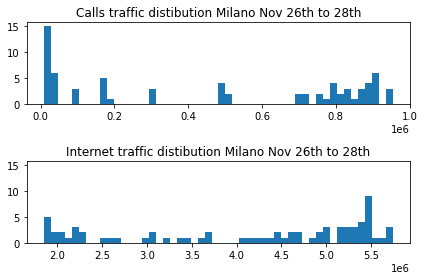

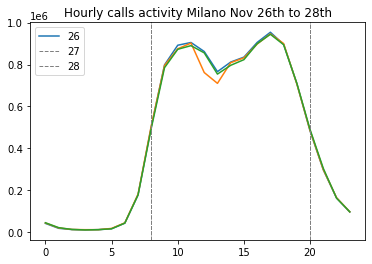

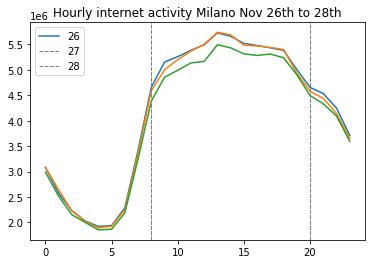

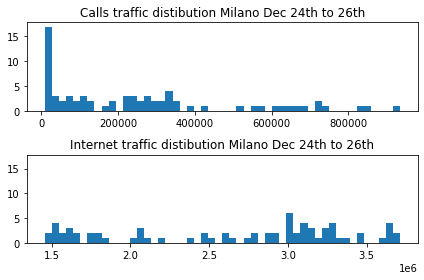

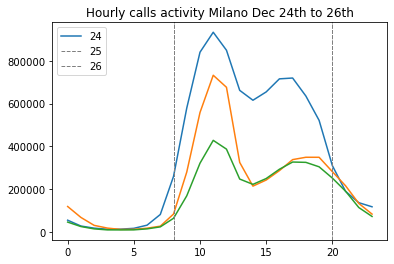

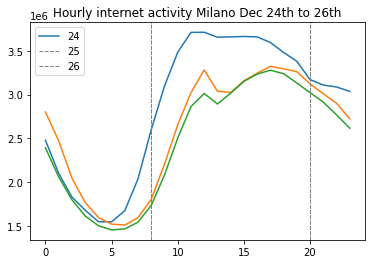

In [12]:
make_histograms(milano_nov, "Milano Nov 26th to 28th")
make_histograms(milano_dec, "Milano Dec 24th to 26th")

### 5. Find correlation between user communication activity and different weather conditions (e.g. rain, snow etc.) in Milan and Trentino.

Milano weather dataset columns:

1. Timestamp: timestamp value with the following format: YYYYMMDDHHmm;

2. Square id: id of a given square of Milan/Trentino GRID;

3. Intensity: intensity value of the precipitation. It is a value between 0 and 3;

4. Coverage: percentage value of the quadrant covered by the precipitation;

5. Type: type of the precipitation. It is a value between 0 and 2.

Trentino weather dataset columns:

1. Timestamp: timestamp value with the following format: YYYYMMDDHHmm;

2. Square id: id of a given square of Milan/Trentino GRID;

3. Intensity: intensity value of the precipitation. It is a value between 0 and 18.

Trentino precipitation intensity values mean following:

1. very slight: precipitation intensity defined [1,3] meaning an amount of [0.20,2.0] mm/hr.

2. slight: precipitation intensity defined [4,6] meaning an amount of [2.0,7.0] mm/hr.

3. moderate: precipitation intensity defined [7,9] meaning an amount of [7.0,16.0] mm/hr.

4. heavy: precipitation intensity defined [10,12] meaning an amount of [16.0,30.0] mm/hr.

5. very heavy: precipitation intensity defined [13,15] meaning an amount of [30.0,70.0] mm/hr.

6. extreme: precipitation intensity defined [16,18] meaning an amount of more than 70 mm/hr.

As precipitation intensity is only common information we have from the Milano and Trentino, we will use that. Both datasets use different number precitation intensity groups, and we don't know the exact intensity numbers for Milano, we are not able to convert them to same intensity classes. For this reason, we will study correlation between Milan and Trentino separately.

#### First define function to read multiple telecom files and join them to singe SFrame

We will create new telecom joining function, because this time we need the timestamps and square ID's to join telecom data to weather data. Also, because weather can change multiple times in a hour, we don't want to use hourly data.

In [87]:
# Define function to read multiple telecom files and append them to one SFrame
def create_telecom_SFrame(paths, start_date, end_date):
    # Measure time how long it takes. Set start time.
    start = time.time()
    
    # Filter paths by start_date and end_date
    # Path example: sms-call-internet-mi-2013-12-01.txt
    wanted_paths = []
    for path in paths:
        date = int(path[-6:-4])
        if (date <= end_date) and (date >= start_date):
            wanted_paths.append(path)
    
    # Read the files and append dataframes to result_df
    result_df = pd.DataFrame(columns = ["time", "SquareID", "total"])
    for path in wanted_paths:
        day = path[-6:-4]
        df = pd.read_csv(path, sep="\t", header=None)
        df = df.fillna(0)
        df.columns = ["SquareID", "time", "country_code", "SMSin", "SMSout", "call_in" ,"call_out", "internet_traffic"]
        df['total'] = df['SMSin']+df['SMSout']+df['call_in']+df['call_out']+df['internet_traffic']
        df = df.drop(['country_code', 'SMSin', 'SMSout', 'call_in', 'call_out', 'internet_traffic'], axis=1)
        result_df= result_df.append(df)
    
    # Convert Pandas dataframe to SFrame
    sf = SFrame(data=result_df)
    
    # Change timestamp type to same format as with weather data. Drop old time columns
    sf["timestamp"] = sf["time"].apply(lambda timestamp: arrow.get(timestamp).format('YYYYMMDDHHmm'))
    sf = sf.remove_column('time')
    
    # Print time how long it took
    end = time.time()
    print("Time to run function was", round(end - start), "seconds")

    # Return results
    return sf

#### Use create_telecom_SFrame to read multiple files, then join monthly files, one to Milano and one to Trentino

In [88]:
# Set paths to telecom files
data_paths_milano_nov = glob2.glob("data/milano_telecom_nov/*")
data_paths_milano_dec = glob2.glob("data/milano_telecom_dec/*")
data_paths_trentino_nov = glob2.glob("data/trento_telecom_nov/*")
data_paths_trentino_dec = glob2.glob("data/trento_telecom_dec/*")

# Use create_telecom_SFrame to read paths and join the files within given dates
milano_tele_nov = create_telecom_SFrame(data_paths_milano_nov, 26, 28)
milano_tele_dec = create_telecom_SFrame(data_paths_milano_dec, 24, 26)
trentino_tele_nov = create_telecom_SFrame(data_paths_trentino_nov, 26, 28)
trentino_tele_dec = create_telecom_SFrame(data_paths_trentino_dec, 24, 26)

# Append Milano_tele_dec and Milano_tele_nov to same SFrame
# Do same to trentino telecom data
milano_tele = milano_tele_nov.append(milano_tele_dec)
trentino_tele = trentino_tele_nov.append(trentino_tele_dec)

# Print 5 first rows
milano_tele.print_rows(num_rows=5)
trentino_tele.print_rows(num_rows=5)

Time to run function was 17 seconds
Time to run function was 14 seconds
Time to run function was 7 seconds
Time to run function was 11 seconds
+----------+----------------------+--------------+
| SquareID |        total         |  timestamp   |
+----------+----------------------+--------------+
|    1     | 0.05701250935247165  | 201311252300 |
|    1     |  11.138522744511373  | 201311252300 |
|    1     | 0.003574620210998875 | 201311252310 |
|    1     |  10.801368105625238  | 201311252310 |
|    1     |  10.108537937984984  | 201311252320 |
+----------+----------------------+--------------+
[30497069 rows x 3 columns]

+----------+---------------------+--------------+
| SquareID |        total        |  timestamp   |
+----------+---------------------+--------------+
|  10000   |  7.619726669813878  | 201311272300 |
|  10000   |  8.406653673442118  | 201311272310 |
|  10000   |  7.418198241119901  | 201311272320 |
|  10000   | 0.04160227556299593 | 201311272330 |
|  10000   |  9.395

### Read weather data and join it to telecom data

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/MeteoMilano_01-11-13_01-01-14.csv

Parsing completed. Parsed 100 lines in 0.011892 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/MeteoMilano_01-11-13_01-01-14.csv

Parsing completed. Parsed 33316 lines in 0.015941 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/precipitation-trentino.csv

Parsing completed. Parsed 100 lines in 0.312327 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 2489903 lines. Lines per second: 4.89761e+06

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/precipitation-trentino.csv

Parsing completed. Parsed 3489417 lines in 0.590487 secs.

Milano intensity classes: [0, 1, 2, 3]
Trentino intensity classes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


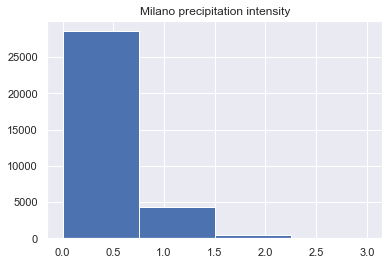

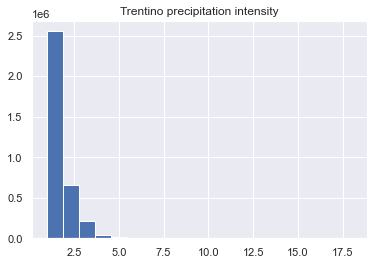

+--------------+----------+-----------+
|  timestamp   | SquareID | intensity |
+--------------+----------+-----------+
| 201311010000 |    1     |     0     |
| 201311010000 |    2     |     0     |
| 201311010000 |    3     |     0     |
| 201311010000 |    4     |     0     |
| 201311010010 |    1     |     0     |
+--------------+----------+-----------+
[33316 rows x 3 columns]

+--------------+----------+-----------+
|  timestamp   | SquareID | intensity |
+--------------+----------+-----------+
| 201311010000 |   2383   |     1     |
| 201311010020 |   9452   |     1     |
| 201311010020 |   8278   |     1     |
| 201311010020 |   6871   |     2     |
| 201311010020 |   5689   |     3     |
+--------------+----------+-----------+
[3489417 rows x 3 columns]



In [89]:
# Set paths to weather files
milano_weather_path = 'data/MeteoMilano_01-11-13_01-01-14.csv'
trentino_weather_path = 'data/precipitation-trentino.csv'

# Read weather files
milano_weather = SFrame.read_csv(milano_weather_path, sep=",", header=None)
trentino_weather = SFrame.read_csv(trentino_weather_path, sep=",", header=None)

# Rename columns of the weather SFrames
milano_weather = milano_weather.rename({'X1':'timestamp', 'X2':'SquareID', 'X3':"intensity", "X4":"coverage", "X5":"type"})
trentino_weather = trentino_weather.rename({'X1': 'timestamp', 'X2':'SquareID', 'X3':"intensity"})

# Drop coverage and type from Milano weather data, because we will only study 
# how intensity affects to the communication activity.
milano_weather = milano_weather.remove_column('coverage')
milano_weather = milano_weather.remove_column('type')

# Print unique intensity values in Milano and Trentino
# Used to make sure, that data decription is corrrect.
print("Milano intensity classes:", sorted(list(milano_weather["intensity"].unique())))
print("Trentino intensity classes:", sorted(list(trentino_weather["intensity"].unique())))

# Make intensity histograms to see intensity distribution in Milan and Trentino.
# Milan and Trentino precipitation intensity has different scales.
# Milan scale is 0-4 and Trentino 1-18.
plt.hist(milano_weather["intensity"], bins=4)
plt.title("Milano precipitation intensity")
plt.show()
plt.hist(trentino_weather["intensity"], bins=19)
plt.title("Trentino precipitation intensity")
plt.show()

# Print first rows
milano_weather.print_rows(num_rows=5)
trentino_weather.print_rows(num_rows=5)

### Join telecom and weather data

In [94]:
# First set SFrames column timestamp and SquareID to int
milano_tele["timestamp"] = milano_tele["timestamp"].astype(int)
milano_tele["SquareID"] = milano_tele["SquareID"].astype(int)
milano_weather["timestamp"] = milano_weather["timestamp"].astype(int)
milano_weather["SquareID"] = milano_weather["SquareID"].astype(int)

trentino_tele["timestamp"] = trentino_tele["timestamp"].astype(int)
trentino_tele["SquareID"] = trentino_tele["SquareID"].astype(int)
trentino_weather["timestamp"] = trentino_weather["timestamp"].astype(int)
trentino_weather["SquareID"] = trentino_weather["SquareID"].astype(int)

# Join weather and telecom datasets
milano = milano_weather.join(milano_tele, on=['timestamp', "SquareID"], how='inner')
trentino = trentino_weather.join(trentino_tele, on=['timestamp', "SquareID"], how='inner')

# Print first rows
milano.print_rows(num_rows=5)
trentino.print_rows(num_rows=5)

+--------------+----------+-----------+----------------------+
|  timestamp   | SquareID | intensity |        total         |
+--------------+----------+-----------+----------------------+
| 201311252300 |    1     |     0     | 0.05701250935247165  |
| 201311252300 |    1     |     0     |  11.138522744511373  |
| 201311252310 |    1     |     0     | 0.003574620210998875 |
| 201311252310 |    1     |     0     |  10.801368105625238  |
| 201311252320 |    1     |     0     |  10.108537937984984  |
+--------------+----------+-----------+----------------------+
[10023 rows x 4 columns]

+--------------+----------+-----------+----------------------+
|  timestamp   | SquareID | intensity |        total         |
+--------------+----------+-----------+----------------------+
| 201311280010 |  10043   |     1     |  2.0012517082797983  |
| 201311281530 |  10095   |     1     | 0.41318456643054674  |
| 201311281530 |  10095   |     1     |  11.279319454692903  |
| 201311281530 |  10095   |  

#### Print correlation values between precipitation intensity and total communication activity

In [114]:
# Milano
df_milano = pd.DataFrame(milano[["intensity", "total"]])
print("Milano intensity vs activity correlation: \n", df_milano.corr(), "\n")

# Trentino
df_trentino = pd.DataFrame(trentino[["intensity", "total"]])
print("Trentino intensity vs activity correlation: \n", df_trentino.corr())

Milano intensity vs activity correlation: 
            intensity     total
intensity   1.000000 -0.018433
total      -0.018433  1.000000 

Trentino intensity vs activity correlation: 
            intensity     total
intensity   1.000000 -0.013226
total      -0.013226  1.000000


#### Make correlation matrix of intensity and total activity

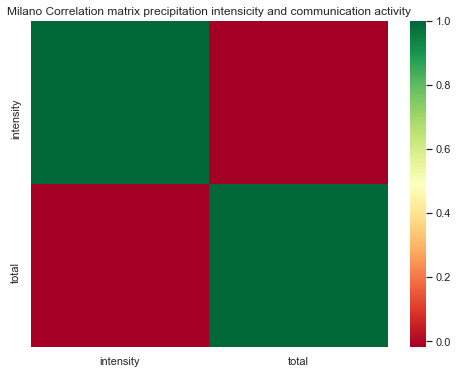

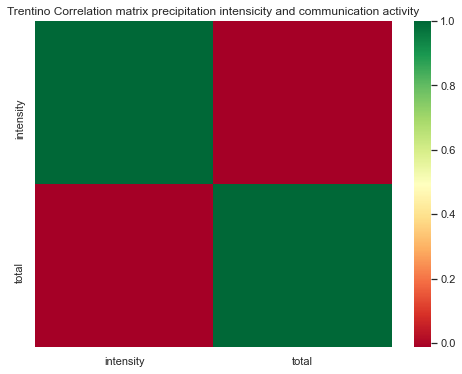

In [109]:
# Milano
corrmat_milano = df_milano.corr()
corr_features_milano = corrmat_milano.index
plt.figure(figsize=(8,6))
plt.title("Milano Correlation matrix precipitation intensicity and communication activity")
g=sns.heatmap(df_milano[corr_features_milano].corr(),annot=False,cmap="RdYlGn")

# Trentino
corrmat_trentino = df_trentino.corr()
corr_features_trentino = corrmat_trentino.index
plt.figure(figsize=(8,6))
plt.title("Trentino Correlation matrix precipitation intensicity and communication activity")
g=sns.heatmap(df_trentino[corr_features_trentino].corr(),annot=False,cmap="RdYlGn")

### Make histograms of total activity with different precipitation intencities

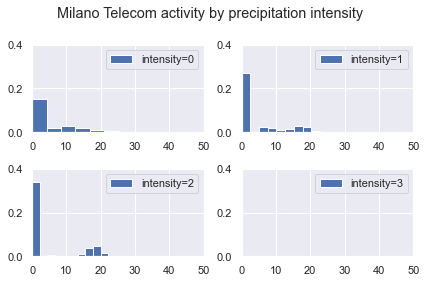

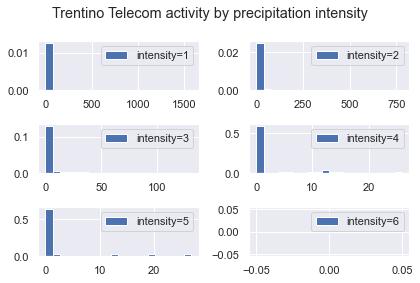

In [163]:
# Split Milano weather data, bases in intensity, to 4 groups (intensity classes 0 to 3).
milano_w0 = milano.filter_by(0, 'intensity')
milano_w1 = milano.filter_by(1, 'intensity')
milano_w2 = milano.filter_by(2, 'intensity')
milano_w3 = milano.filter_by(3, 'intensity')

# Split Milano weather data, bases on intensity, to 6 groups (intensity classes 1 to 6).
trentino_w1 = trentino[(trentino['intensity'] >= 1) & (trentino['intensity'] <= 3)]
trentino_w2 = trentino[(trentino['intensity'] >= 4) & (trentino['intensity'] <= 6)]
trentino_w3 = trentino[(trentino['intensity'] >= 7) & (trentino['intensity'] <= 9)]
trentino_w4 = trentino[(trentino['intensity'] >= 10) & (trentino['intensity'] <= 12)]
trentino_w5 = trentino[(trentino['intensity'] >= 13) & (trentino['intensity'] <= 15)]
trentino_w6 = trentino[(trentino['intensity'] >= 16) & (trentino['intensity'] <= 18)]

# Make Milano histograms. One for each precipitation intensity class.
fig, ax = plt.subplots(2, 2, sharey=True, tight_layout=True)
plt.subplot(2, 2, 1)
plt.xlim(0, 50)
plt.ylim(0, 0.4)
plt.hist(milano_w0["total"], bins=10, density=True)
plt.legend(["intensity=0"], loc ="upper right") 
plt.subplot(2, 2, 2)
plt.xlim(0, 50)
plt.ylim(0, 0.4)
plt.hist(milano_w1["total"], bins=10, density=True)
plt.legend(["intensity=1"], loc ="upper right") 
plt.subplot(2, 2, 3)
plt.xlim(0, 50)
plt.ylim(0, 0.4)
plt.hist(milano_w2["total"], bins=10, density=True)
plt.legend(["intensity=2"], loc ="upper right") 
plt.subplot(2, 2, 4)
plt.xlim(0, 50)
plt.ylim(0, 0.4)
plt.hist(milano_w3["total"], bins=10, density=True)
plt.legend(["intensity=3"], loc ="upper right")  
plt.suptitle('Milano Telecom activity by precipitation intensity')
plt.show()

# Make Trentino histograms. One for each precipitation intensity class.
fig, ax = plt.subplots(3, 2, sharey=True, tight_layout=True)
# Histogram 1
plt.subplot(3, 2, 1)
#plt.ylim(0, 0.4)
plt.hist(trentino_w1["total"], bins=20, density=True)
plt.legend(["intensity=1"], loc ="upper right") 
# Histogram 2
plt.subplot(3, 2, 2)
#plt.ylim(0, 0.4)
plt.hist(trentino_w2["total"], bins=20, density=True)
plt.legend(["intensity=2"], loc ="upper right") 
# Histogram 3
plt.subplot(3, 2, 3)
#plt.ylim(0, 0.4)
plt.hist(trentino_w3["total"], bins=20, density=True)
plt.legend(["intensity=3"], loc ="upper right") 
# Histogram 4
plt.subplot(3, 2, 4)
#plt.ylim(0, 0.4)
plt.hist(trentino_w4["total"], bins=20, density=True)
plt.legend(["intensity=4"], loc ="upper right") 
# Histogram 5
plt.subplot(3, 2, 5)
#plt.ylim(0, 0.4)
plt.hist(trentino_w5["total"], bins=20, density=True)
plt.legend(["intensity=5"], loc ="upper right")  
# Histogram 6
plt.subplot(3, 2, 6)
#plt.ylim(0, 0.4)
plt.hist(trentino_w6["total"], bins=20, density=True)
plt.legend(["intensity=6"], loc ="upper right")  
plt.suptitle('Trentino Telecom activity by precipitation intensity')
plt.show()


## 6. Plot the heatmap of user telecommunication activity for both Milan and Trentino. Do you observe any shift in communication pattern of users between day and night? (A typical day time is between 8AM to 8PM)



In [15]:
# Execute the glob function that returns a list of filepaths
data_paths_milano_nov = glob2.glob("data/milano_telecom_nov/*")
data_paths_trento_nov = glob2.glob("data/trento_telecom_nov/*")

# Use create_telecom_SFrame to read paths and join the files within given dates
milano_nov_tele = create_hourly_telecom_SFrame(data_paths_milano_nov, 26, 28)
trento_nov_tele = create_hourly_telecom_SFrame(data_paths_trento_nov, 26, 28)

# Print first 5 rows
milano_nov_tele.print_rows(num_rows=5)
trento_nov_tele.print_rows(num_rows=5)


#trento_busy_hours = dec_day_con(trento_time)
#trento_time = gl.SFrame(trento_telecom)
#trento_plots.show(columns=['time_interval', 'total'],view='Heat Map', x='time_interval', y='total')

Time to run function was 83 seconds
Time to run function was 0 seconds
+-----+------+--------------------+--------------------+
| day | hour |    int_traffic     |       calls        |
+-----+------+--------------------+--------------------+
|  26 |  0   | 3081805.3777902257 | 41192.73183245975  |
|  26 |  1   | 2572701.7786852913 | 17706.488070584088 |
|  26 |  2   | 2231849.1340871626 | 11778.29144326302  |
|  26 |  3   | 2032399.1755711306 | 10178.701211725678 |
|  26 |  4   | 1922521.870940004  | 11383.318199818337 |
+-----+------+--------------------+--------------------+
[72 rows x 4 columns]

+-----+------+-------------+-------+
| day | hour | int_traffic | calls |
+-----+------+-------------+-------+
+-----+------+-------------+-------+
[0 rows x 4 columns]



## 7. Investigate and plot the correlation between air quality and weather (temperature, sunshine, precipitation, etc.).

In [16]:
# Define function to read and join all Milano pollution data files
def milano_pollution(paths):
    # Initialize empty SFrame
    #result_df = pd.DataFrame(columns = ["SquareID", "Time", "country_code"])
    results_sf = SFrame({'X1':[],'X2':[], 'X3':[]})
    results_sf["X1"] = results_sf["X1"].astype(int)
    results_sf["X2"] = results_sf["X2"].astype(str)
    results_sf["X3"] = results_sf["X3"].astype(int)
    
    # Add pollution data one by one to results_sf
    for path in paths:
        # Read file
        sf_tmp = SFrame.read_csv(path, sep=",", header=None)
        # Set column types
        sf_tmp["X1"] = sf_tmp["X1"].astype(int)
        sf_tmp["X2"] = sf_tmp["X2"].astype(str)
        sf_tmp["X3"] = sf_tmp["X3"].astype(int)
        # Append sf_tmp to results_sf
        results_sf = results_sf.append(sf_tmp)
    # Rename columns
    sf_tmp = sf_tmp.rename({'X1': 'xxx1', 'X2':'time', 'X3':"xxx3"})
    # Return SFrame with all Milano pollution data
    return results_sf

# Define path to folder of Milano pollution data files
milano_pollution_paths = glob2.glob("data/milano_pollution_data/*")

# Run milano_pollution function and get all Milano pollution data
milano_pollution = milano_pollution(milano_pollution_paths)

milano_pollution

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6956.csv

Parsing completed. Parsed 54 lines in 0.019206 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6956.csv

Parsing completed. Parsed 54 lines in 0.005541 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5722.csv

Parsing completed. Parsed 100 lines in 0.005905 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5722.csv

Parsing completed. Parsed 1353 lines in 0.006074 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6372.csv

Parsing completed. Parsed 100 lines in 0.006324 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6372.csv

Parsing completed. Parsed 1460 lines in 0.006313 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6366.csv

Parsing completed. Parsed 100 lines in 0.006514 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6366.csv

Parsing completed. Parsed 1312 lines in 0.006143 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5531.csv

Parsing completed. Parsed 100 lines in 0.007665 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5531.csv

Parsing completed. Parsed 1312 lines in 0.006365 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5725.csv

Parsing completed. Parsed 100 lines in 0.006389 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5725.csv

Parsing completed. Parsed 1312 lines in 0.006019 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10278.csv

Parsing completed. Parsed 100 lines in 0.006312 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10278.csv

Parsing completed. Parsed 1459 lines in 0.006536 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10279.csv

Parsing completed. Parsed 100 lines in 0.00629 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10279.csv

Parsing completed. Parsed 1461 lines in 0.006182 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5542.csv

Parsing completed. Parsed 100 lines in 0.007237 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5542.csv

Parsing completed. Parsed 1462 lines in 0.006149 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6328.csv

Parsing completed. Parsed 100 lines in 0.006028 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6328.csv

Parsing completed. Parsed 1460 lines in 0.005522 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6062.csv

Parsing completed. Parsed 100 lines in 0.005787 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6062.csv

Parsing completed. Parsed 1461 lines in 0.005983 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_20020.csv

Parsing completed. Parsed 100 lines in 0.006007 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_20020.csv

Parsing completed. Parsed 743 lines in 0.006091 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10280.csv

Parsing completed. Parsed 100 lines in 0.0061 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10280.csv

Parsing completed. Parsed 1352 lines in 0.005825 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5552.csv

Parsing completed. Parsed 100 lines in 0.008856 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5552.csv

Parsing completed. Parsed 1462 lines in 0.005603 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5550.csv

Parsing completed. Parsed 100 lines in 0.005692 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5550.csv

Parsing completed. Parsed 1062 lines in 0.005617 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10282.csv

Parsing completed. Parsed 100 lines in 0.005668 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10282.csv

Parsing completed. Parsed 1461 lines in 0.005611 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10283.csv

Parsing completed. Parsed 61 lines in 0.00539 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10283.csv

Parsing completed. Parsed 61 lines in 0.00545 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5551.csv

Parsing completed. Parsed 100 lines in 0.00593 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5551.csv

Parsing completed. Parsed 1462 lines in 0.006268 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10320.csv

Parsing completed. Parsed 59 lines in 0.005337 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10320.csv

Parsing completed. Parsed 59 lines in 0.005391 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_17126.csv

Parsing completed. Parsed 100 lines in 0.005945 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_17126.csv

Parsing completed. Parsed 1461 lines in 0.005732 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_17127.csv

Parsing completed. Parsed 100 lines in 0.005836 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_17127.csv

Parsing completed. Parsed 1484 lines in 0.00551 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_20004.csv

Parsing completed. Parsed 100 lines in 0.006641 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_20004.csv

Parsing completed. Parsed 692 lines in 0.005557 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6320.csv

Parsing completed. Parsed 100 lines in 0.005687 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6320.csv

Parsing completed. Parsed 1462 lines in 0.005603 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10273.csv

Parsing completed. Parsed 61 lines in 0.005361 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_10273.csv

Parsing completed. Parsed 61 lines in 0.005288 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5827.csv

Parsing completed. Parsed 100 lines in 0.00684 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5827.csv

Parsing completed. Parsed 1461 lines in 0.005331 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_20005.csv

Parsing completed. Parsed 88 lines in 0.00518 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_20005.csv

Parsing completed. Parsed 88 lines in 0.005257 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6057.csv

Parsing completed. Parsed 100 lines in 0.00573 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6057.csv

Parsing completed. Parsed 1462 lines in 0.005402 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5823.csv

Parsing completed. Parsed 100 lines in 0.005739 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5823.csv

Parsing completed. Parsed 1462 lines in 0.005605 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5834.csv

Parsing completed. Parsed 100 lines in 0.005671 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5834.csv

Parsing completed. Parsed 1462 lines in 0.006582 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_17122.csv

Parsing completed. Parsed 59 lines in 0.00549 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_17122.csv

Parsing completed. Parsed 59 lines in 0.005401 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6354.csv

Parsing completed. Parsed 100 lines in 0.006055 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6354.csv

Parsing completed. Parsed 1462 lines in 0.005563 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6340.csv

Parsing completed. Parsed 100 lines in 0.005585 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6340.csv

Parsing completed. Parsed 1061 lines in 0.005554 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5841.csv

Parsing completed. Parsed 100 lines in 0.005877 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5841.csv

Parsing completed. Parsed 1461 lines in 0.005613 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5504.csv

Parsing completed. Parsed 100 lines in 0.005712 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5504.csv

Parsing completed. Parsed 1461 lines in 0.005714 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5506.csv

Parsing completed. Parsed 100 lines in 0.005664 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_5506.csv

Parsing completed. Parsed 1460 lines in 0.0057 secs.

Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6344.csv

Parsing completed. Parsed 100 lines in 0.005796 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/saukk/Desktop/Distributed data infrastucture/GraphLab project/data/milano_pollution_data/mi_pollution_6344.csv

Parsing completed. Parsed 1461 lines in 0.00552 secs.

X1,X2,X3
6956,2013/11/01,41
6956,2013/11/02,55
6956,2013/11/03,42
6956,2013/11/04,32
6956,2013/11/05,35
6956,2013/11/06,35
6956,2013/11/07,67
6956,2013/11/08,76
6956,2013/11/09,43
6956,2013/11/10,26


# Answers:
### In the answers I have used dates 26-28th November and 24-26th December

### Read telecom data

In [ ]:
# Create function to join multiple files, filter by date, and join to single dataframe    
def create_telecom_SFrame(paths, start_date, end_date):
    # Measure time how long it takes. Set start time.
    start = time.time()
    
    # Filter paths by start_date and end_date
    # Path example: sms-call-internet-mi-2013-12-01.txt
    wanted_paths = []
    for path in data_paths:
        date = int(path[-6:-4])
        if (date <= end_date) and (date >= start_date):
            wanted_paths.append(path)
    
    # Read the files and append dataframes to result_df
    result_df = pd.DataFrame(columns = ["SquareID", "Time", "country_code", "SMSin", "SMSout", "call_in" ,"call_out", "Internet_Traffic"])
    for path in wanted_paths:
        df = pd.read_csv(path, sep="\t", header=None)
        #df = df.fillna(0)
        df.columns = ["SquareID", "Time", "country_code", "SMSin", "SMSout", "call_in" ,"call_out", "Internet_Traffic"]
        result_df= result_df.append(df)
    
    # Convert Pandas dataframe to SFrame
    result_SFrame = SFrame(data=result_df)
    
    # Add UTC_time columns. Running this row takes about 5mins.
    #result_df["UTCtime"] = result_df["Time"].apply(lambda timestamp: arrow.get(timestamp).format('MMM Do YYYY HH:mm'))
    
    # Print time how long it took
    end = time.time()
    print("Time to run function was", round(end - start), "seconds")

    # Return results
    return result_SFrame


In [ ]:
# Execute the glob function that returns a list of filepaths
data_paths_milano_nov = glob2.glob("data/milano_telecom_nov/*")
data_paths_milano_dec = glob2.glob("data/milano_telecom_dec/*")
data_paths_trento_nov = glob2.glob("data/trento_telecom_nov/*")
data_paths_trento_dec = glob2.glob("data/trento_telecom_dec/*")

# Use create_telecom_SFrame to read paths and join the folders with given date
milano_nov = create_telecom_SFrame(data_paths_milano_nov, 26, 28)
#milano_dec = create_telecom_SFrame(data_paths_milano_dec, 24, 26)
#trento_nov = create_telecom_SFrame(data_paths_trento_nov, 26, 28)
#trento_dec = create_telecom_SFrame(data_paths_trento_dec, 26, 28)

milano_nov

In [ ]:
df["time2"] = df["Time"].apply(lambda timestamp: arrow.get(timestamp).format('MMM Do YYYY HH:mm'))

In [ ]:
df